# **Rizzlite Word Ranking**

## **Preprocess Manually Ranked Sentences**

### Import necessary libraries

In [1]:
import requests
import pandas as pd
import random
import csv
import re
import contractions
from random import uniform
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/skylerestavillo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Create personalized list of stop words, which will be set to neutral score

In [2]:
# Create personalized list of stop words
stop_words = [ "of", "should", "not", "are", "i", "her", "here", "their", "again", "can", "above", "these", "will", "all", 
"them", "has", "she", "him", "his", "itself", "it", "is", "out", "had", "he", "hers", "because", "were", "than", "not",
"and", "under", "during", "into", "am", "have", "yours", "a", "some", "have", "has", "ours", "or", "by", "our", "at",
"on", "same", "you", "does", "was", "did", "theirs", "herself", "himself",
"does", "they", "up", "between", "such", "both", "nor", "having", "are", "an", "no", "ain't", "as", "before", "with",
"have", "other", "she", "in", "for", "themselves", "do", "the", "against", "so", "ourselves", "to", "did",
"doing", "each", "been", "has", "after", "off", "but", "through", "it", "this", "own",
"any", "now", "if", "while", "down", "only", "being", "my", "had", "we", "then", "until", "from",
"further", "there", "that", "went", "those"]

word_scores = {}

for word in set(stop_words):
    word_scores[word] = 3

### Define function to preprocess sentences

In [3]:
# Define a function to preprocess each sentence
def preprocess_sentence(sentence):
    # Convert the input to a string and then to lowercase
    sentence = str(sentence).lower()
    
    # Remove words containing numbers from the sentence
    sentence = re.sub(r'\b\w*\d\w*\b', '', sentence)
    
    # Break apart contractions using the contractions library
    sentence = contractions.fix(sentence)
    
    # Remove all non-alphabetic characters from the sentence
    sentence = re.sub(r'[^a-zA-Z\s]', '', sentence)
    
    # Ensure the sentence is returned as a string of words
    sentence = ' '.join(sentence.split())
    
    return sentence

### Read csv file, preprocess, and set scores

In [4]:
# Read in the csv file
df = pd.read_csv('SentenceCorpus.csv')


# Preprocess each sentence in the 'Sentence' column
df['Sentence'] = df['Sentence'].apply(preprocess_sentence)

# Print the updated dataframe
print(df.head())

# Define a function to tokenize a sentence and return a list of words
def tokenize(sentence):
    return sentence.split()

# Update the word_scores dictionary with words and their scores
for index, row in df.iterrows():
    sentence = row['Sentence']
    score = row['Score']
    words = tokenize(sentence)

    # If its a new non stop word, add it to the dictionary
    # If we've seen it before, append the new score to the list of scores
    for word in words:
        if word not in stop_words:
            if word not in word_scores:
                word_scores[word] = [score]
            else:
                word_scores[word].append(score)

# Calculate the average score for each word
word_final_scores = {}
for word, scores in word_scores.items():
    if isinstance(scores, list):
        word_final_scores[word] = sum(scores) / len(scores)
    else:
        word_final_scores[word] = scores

    id language                                   Sentence  Score Unnamed: 4
0  0.0      eng                       let us try something    3.5        NaN
1  1.0      eng                      i have to go to sleep    3.7        NaN
2  2.0      eng  today is june and it is muiriels birthday    4.2        NaN
3  3.0      eng                             muiriel is now    4.8        NaN
4  4.0      eng                    the password is muiriel    4.8        NaN


### Test our dictionary

In [5]:
# Print the count of all words in the dictionary
print(f"Total words in the dictionary: {len(word_final_scores)}")

# Print 10 random words in the dictionary with their associated scores
random_words = random.sample(list(word_final_scores.items()), 10)
for word, score in random_words:
    print(f"{word}: {score}")

Total words in the dictionary: 2617
handsome: 5.0
won: 4.15
analysis: 2.5
travel: 2.8666666666666667
infirmary: 3.8
arrived: 3.85
here: 3
criticism: 5.0
letter: 1.7333333333333334
glasses: 3.5666666666666664


### Define API Request Functions

In [66]:
API_KEY = "YOUR KEY HERE"

# Define synonym API request
def get_synonyms(word):
    url = f"https://wordsapiv1.p.rapidapi.com/words/{word}/synonyms"
    headers = {
        "content-type": "application/octet-stream",
        "X-RapidAPI-Key": API_KEY,
        "X-RapidAPI-Host": "wordsapiv1.p.rapidapi.com"
    }
    response = requests.get(url, headers=headers)
    return response.json().get('synonyms', [])


# Definition definition API request
def get_definition(word):
    url = f"https://wordsapiv1.p.rapidapi.com/words/{word}/definitions"
    headers = {
        "content-type": "application/octet-stream",
        "X-RapidAPI-Key": API_KEY,
        "X-RapidAPI-Host": "wordsapiv1.p.rapidapi.com"
    }
    response = requests.get(url, headers=headers)
    return response.json().get('definitions', [])

## Grow Dataset with Synonyms and Definitions From API Calls

In [68]:
# Import model
from gensim.models import Word2Vec
import gensim.downloader as api
from gensim.models import KeyedVectors

glove_model = api.load('glove-twitter-200')

### Functions to save progress into dictionary

In [6]:
def save_word_final_scores_to_csv():
    with open('word_scores.csv', 'w', newline='') as csvfile:
        fieldnames = ['Word', 'Score']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for word, score in word_final_scores.items():
            writer.writerow({'Word': word, 'Score': score})
    print("Progress saved to word_scores.csv")


### Call Function to Save Progress Along the Way

In [ ]:
save_word_final_scores_to_csv()

### Define/Redefine global variables and re-read data into them from previous iterations

In [7]:
called_words = set()
used_words = set()

Call the read function only if you've built the necessary csv files (called below in random_k function)

#### Read function

In [8]:
used_words.clear()
called_words.clear()

# Read used_words back into the used_words set
with open("used_words.csv", "r", newline="", encoding="utf-8") as csvfile:
    csv_reader = csv.reader(csvfile)
    next(csv_reader)  # Skip the header
    used_words = {row[0] for row in csv_reader}

# Read called_words back into the called_words set
with open("called_words.csv", "r", newline="", encoding="utf-8") as csvfile:
    csv_reader = csv.reader(csvfile)
    next(csv_reader)  # Skip the header
    called_words = {row[0] for row in csv_reader}

#### Write function

In [ ]:
# Write used_words to CSV file
with open("used_words.csv", "w", newline="", encoding="utf-8") as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(["Word"])
    for word in used_words:
        csv_writer.writerow([word])

# Write called_words to CSV file
with open("called_words.csv", "w", newline="", encoding="utf-8") as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(["Word"])
    for word in called_words:
        csv_writer.writerow([word])

### Re-read values into our dictionary obtained from previous iterations (if created)

In [9]:
word_final_scores.clear()

# Read word_scores.csv file
df = pd.read_csv("word_scores.csv")

# Preprocess the data
df["Word"] = df["Word"].astype(str)
df = df[df["Word"].apply(lambda x: not any(char.isdigit() for char in x))]
df["Word"] = df["Word"].apply(lambda x: re.sub(r'[^ \w+]', '', x))  # Remove non-alphanumeric characters except spaces
df = df[df["Word"] != ""]  # Remove rows with empty strings
df["Word"] = df["Word"].apply(lambda x: x.lower())  # Convert the word to lowercase



# Add words and scores to the word_final_scores dictionary
for index, row in df.iterrows():
    word_final_scores[row["Word"]] = row["Score"]


# Add words and scores to the word_scores dictionary!!
# !! This is the dictionary that is clean and will generate random words
for index, row in df.iterrows():
    word_scores[row["Word"]] = row["Score"]

### Function to clean definition words and synonyms from API calls

In [10]:
def clean_word(word):
    if not isinstance(word, str):
        word = str(word)
    if any(char.isdigit() for char in word):
        return None
    word = re.sub(r'[^ \w+]', '', word)  # Remove non-alphanumeric characters except spaces
    if word == "":
        return None
    word = word.lower()
    return word

### **Call the API Function**

In [104]:
api_limit = 20000
api_calls_made = 13923

def k_nearest_neighbors(word, k=10, use_api = True, api_limit=20000):
    global api_calls_made, called_words

    # Use the Words API to find synonyms if the use_api flag is set to True and the API limit is not exceeded
    if use_api and word not in called_words and api_limit > 0 and api_calls_made < api_limit:
        # Add the word to the called_words set to prevent duplicate API calls
        called_words.add(word)
        api_calls_made += 1  # Increment the API calls counter

        synonyms = get_synonyms(word)
        # If the API returns synonyms, return the list of synonyms
        for synonym in synonyms[:k]:
            synonym = clean_word(synonym)
            if synonym and synonym not in word_final_scores: # if synonym is not none and not in word_final_scores
                print(f"Getting definition for {synonym}")
                api_calls_made += 1  # Increment the API calls counter
                # This may return more than 1 definition, so we need to iterate through each definition
                definitions = get_definition(synonym)
                definition_score = 0 
                word_count = 0
                new_words = set()  # Initialize a set to store new words found in the definition
                for definition in definitions:
                    # For words in the definition, check if they are in the word_final_scores dictionary
                    for def_word in definition['definition'].split():
                        def_word = clean_word(def_word)
                        if def_word and def_word in word_final_scores: # if def_word is not none and in word_final_scores
                            # If the word is in the dictionary, add the score to the definition score and increment the word count
                            definition_score += word_final_scores[def_word]
                            # Increment the word count
                            word_count += 1
                        else:
                            definition_score += 3 # Increase by a neutral number if we this word is new
                            word_count += 1
                            new_words.add(def_word)  # Add the new word to the set for rapid scoring later

                # If the definition has more words than 0, calculate the average definition score
                if word_count > 0:
                    average_definition_score = definition_score / word_count 

                    # If the definition score is slightly higher than OG word, rank synonym higher
                    if average_definition_score > word_final_scores[word]:
                        score_adjustment = uniform(0, 0.2) 
                        new_score = min(5, word_final_scores[word] + score_adjustment)
                    # Else, rank the synonym slightly lower
                    else:
                        score_adjustment = uniform(-0.2, 0)
                        new_score = max(1, word_final_scores[word] + score_adjustment)
                    
                    word_final_scores[synonym] = new_score
                    print(f"Adding word: {synonym} {new_score}")  # Print the added word and its score

                    # For newly encountered words form definition, give them a score close to the synonyms scores
                    for new_word in new_words:
                        adjusted_new_score = max(1, min(5, new_score + uniform(-0.2, 0.2)))
                        word_final_scores[new_word] = adjusted_new_score
                        print(f"Adding word: {new_word} {adjusted_new_score}")  # Print the added word and its score
                # If the definition has no words/no definition returned, assign OG score to the synonym
                else:
                    word_final_scores[synonym] = word_final_scores[word]
                    print(f"Adding word: {synonym} {word_final_scores[synonym]}")  # Print the added word and its score
                    # Assign the synonym's score to each new word found in the definition
                    # Should not happen often, but just in case
                    for new_word in new_words:
                        word_final_scores[new_word] = word_final_scores[word]
                        print(f"Adding word: {new_word} {word_final_scores[new_word]}")  # Print the added word and its score
    else:
        # For a given word, find its first-level neighbors using the GloVe model
        first_level_neighbors = glove_model.most_similar(positive=[word], topn=k)

        for first_neighbor, _ in first_level_neighbors:
            # Find their neighbors (second-level neighbors)
            second_level_neighbors = glove_model.most_similar(positive=[first_neighbor], topn=k)
            scored_second_level_neighbors = [n for n, _ in second_level_neighbors if n in word_final_scores]

            # Calculate the average score of known second-level neighbors
            if len(scored_second_level_neighbors) >= 1:
                # If the first-level neighbor is not in the word_final_scores dictionary, add it. Otherwise, skip
                if first_neighbor not in word_final_scores:
                    avg_score = sum(word_final_scores[n] for n in scored_second_level_neighbors) / len(scored_second_level_neighbors)
                    word_final_scores[first_neighbor] = avg_score
                    print(f"Adding word: {first_neighbor} {avg_score}")

            unknown_second_level_neighbors = []

            # For each unknown second-level neighbor, add it to a list
            for second_neighbor, _ in second_level_neighbors:
                if second_neighbor not in word_final_scores:
                    unknown_second_level_neighbors.append(second_neighbor)

            # For each unknown second-level neighbor, find its neighbors (third-level neighbors)
            for second_neighbor in unknown_second_level_neighbors:
                third_level_neighbors = glove_model.most_similar(positive=[second_neighbor], topn=k)
                scored_third_level_neighbors = [n for n, _ in third_level_neighbors if n in word_final_scores]

                # Try to score the unknown second-level neighbor
                if len(scored_third_level_neighbors) >= 1:
                    # If the second-level neighbor is not in the word_final_scores dictionary, add it. Otherwise, skip
                    if second_neighbor not in word_final_scores:
                        avg_score = sum(word_final_scores[n] for n in scored_third_level_neighbors) / len(scored_third_level_neighbors)
                        word_final_scores[second_neighbor] = avg_score
                        print(f"Adding word: {second_neighbor} {avg_score}")

                # Assign each unknown third-level neighbor a score equal to its respective second-level neighbor's score
                for third_neighbor, _ in third_level_neighbors:
                    if third_neighbor not in word_final_scores:
                        # if we know the second neighbor's score, apply it with some noise
                        if second_neighbor in word_final_scores:
                            adjusted_score = max(1, min(5, word_final_scores[second_neighbor] + uniform(-0.15, 0.15)))
                            word_final_scores[third_neighbor] = adjusted_score
                            print(f"Adding word: {third_neighbor} {adjusted_score}")
                        # if we don't know the second neighbor's score, apply the first neighbor's score with some noise
                        else:
                            adjusted_score = max(1, min(5, word_final_scores[first_neighbor] + uniform(-0.15, 0.15)))
                            word_final_scores[third_neighbor] = adjusted_score
                            print(f"Adding word: {third_neighbor} {adjusted_score}")


    return api_calls_made  # Return the number of API calls made





def random_word_k_nearest_neighbors():
    global api_calls_made
    save_interval = 50
    iterations = 0

    while True:
        # Get the list of words found in our clean dictionary that is a non-stop word not in used_words
        remaining_words = [word for word in word_scores.keys() if word not in stop_words and word not in used_words]

        # Break the loop if there are no remaining words
        if not remaining_words:
            print("No remaining words")
            break

        # Select a random non-stop word from the remaining_words list
        random_word = random.choice(remaining_words)
        used_words.add(random_word)
        print(random_word)

        # Check if the random_word is in the GloVe vocabulary
        if glove_model.has_index_for(random_word):
            # Call k_nearest_neighbors with the random word and use_api set to True if we haven't exceeded the API limit
            use_api = api_calls_made < api_limit
            print(f"Random word: {random_word}")
            api_calls_made = k_nearest_neighbors(random_word, use_api=use_api)
            print(f"Total API calls: {api_calls_made}")
        else:
            print(f"{random_word} not in GloVe vocabulary")

        iterations += 1

        # Print the count of all words in the dictionary
        print(f"Total words in the dictionary: {len(word_final_scores)}")

        # Save the results to the CSV file after every save_interval iterations
        if iterations % save_interval == 0:
            print(f"Saving progress after {iterations} iterations")
            save_word_final_scores_to_csv()
            # Write used_words to CSV file
            with open("used_words.csv", "w", newline="", encoding="utf-8") as csvfile:
                csv_writer = csv.writer(csvfile)
                csv_writer.writerow(["Word"])
                for word in used_words:
                    csv_writer.writerow([word])

            # Write called_words to CSV file
            with open("called_words.csv", "w", newline="", encoding="utf-8") as csvfile:
                csv_writer = csv.writer(csvfile)
                csv_writer.writerow(["Word"])
                for word in called_words:
                    csv_writer.writerow([word])
            

        # Break the loop if you want to stop after a certain number of iterations
        if len(used_words) >= 80000:
            print("used more than 80k words")
            break

### **Call our function**

In [ ]:
random_word_k_nearest_neighbors()

### Save Progress

In [ ]:
print(f"Saving progress")
save_word_final_scores_to_csv()

# Print the count of all words in the dictionary
print(f"Total words in the dictionary: {len(word_final_scores)}")

### Notes
    - by this point we accumulated approximately 28,000 words
        - this is up from our original list of 2,600
        - mostly accomplished through API calls with some GloVe nearest neighbors assistance
    - we will now create our own model with a much larger corpus of sentences
        -we will then leverage this model to rank the remainder of our words

## **Create W2V Model and Rank Remainding Words**

### Read used_words and called_words into csv for later reloading

In [90]:
# Write used_words to CSV file
with open("used_words.csv", "w", newline="", encoding="utf-8") as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(["Word"])
    for word in used_words:
        csv_writer.writerow([word])

# Write called_words to CSV file
with open("called_words.csv", "w", newline="", encoding="utf-8") as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(["Word"])
    for word in called_words:
        csv_writer.writerow([word])

## Write data to a csv file

In [25]:
print(f"Saving progress")
save_word_final_scores_to_csv()

# Print the count of all words in the dictionary
print(f"Total words in the dictionary: {len(word_final_scores)}")

Saving progress
Progress saved to word_scores.csv
Total words in the dictionary: 107649


# Create Word2Vec with Full Sentence Corpus

## Get sentence corpus from hugging face

In [11]:
from datasets import load_dataset
import pandas as pd

dataset = load_dataset('generics_kb', 'generics_kb_best', data_dir='/Volumes/YoMama/RizzeratorLite')
df_unknown = pd.DataFrame(dataset['train'])
#print('Done with df_unknown')
#print(df_unknown.head())

generic_sentences = df_unknown['generic_sentence'].tolist()
#print('Done with generic_sentences')
#print(generic_sentences[:5])
df_generic = pd.DataFrame({'generic_sentence': generic_sentences})
#print('Done with df_generic')
#print(df_generic.head())



# Define a function to preprocess each sentence
def preprocess_sentence(sentence):
    # Convert the input to a string and then to lowercase
    sentence = str(sentence).lower()
    
    # Remove words containing numbers from the sentence
    sentence = re.sub(r'\b\w*\d\w*\b', '', sentence)
    
    # Break apart contractions using the contractions library
    sentence = contractions.fix(sentence)
    
    # Remove all non-alphabetic characters from the sentence
    sentence = re.sub(r'[^a-zA-Z\s]', '', sentence)
    
    # Ensure the sentence is returned as a string of words
    sentence = ' '.join(sentence.split())
    
    return sentence

# Preprocess each sentence in the 'generic_sentence' column
df_generic['generic_sentence'] = df_generic['generic_sentence'].apply(preprocess_sentence)

# Print the updated dataframe
#print(df_generic.head())

# Define a function to tokenize a sentence and return a list of words
def tokenize(sentence):
    return sentence.split()

# Update the total dictionary with all words from all sentences
unscored_dictionary = {}
for index, row in df_generic.iterrows():
    sentence = row['generic_sentence']  # Access the sentence using the column name 'generic_sentence'
    words = tokenize(sentence)

    for word in words:
        if word not in stop_words:
            if word not in word_final_scores:
                unscored_dictionary[word] = 0





/Users/skylerestavillo/opt/anaconda3/envs/rizzlite/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Found cached dataset generics_kb (/Users/skylerestavillo/.cache/huggingface/datasets/generics_kb/generics_kb_best-13621e76244528a1/1.0.0/86da327cb38f53a3d9258e5b8ebbd7f06c766005cd6cf32e36a7f36e04cdab9c)
100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


In [12]:
# Print the count of all words in the dictionary
print(f"Total words in the dictionary: {len(unscored_dictionary)}")

Total words in the dictionary: 37524


## Get sentence corpus from eng_sentences2.csv

In [ ]:
# Read in the full csv file
df_sentence = pd.read_csv('eng_sentences2.csv', header = None)

# Preprocess each sentence in the 'Sentence' column, but there is no header so use column 2
df_sentence[2] = df_sentence[2].apply(preprocess_sentence)

# Print the updated dataframe
print(df_sentence.head())

# Define a function to tokenize a sentence and return a list of words
def tokenize(sentence):
    return sentence.split()

# Update the word_scores dictionary with words and their scores
for index, row in df_sentence.iterrows():
    sentence = row[2]
    score = 0
    words = tokenize(sentence)

    for word in words:
        if word not in stop_words:
            if word not in word_final_scores:
                if word not in unscored_dictionary:
                    unscored_dictionary[word] = 0

In [14]:
# Print the count of all words in the dictionary
print(f"Total words in the unscored dictionary: {len(unscored_dictionary)}")
print(f"Total words in the scored dictionary: {len(word_final_scores)}")

Total words in the unscored dictionary: 47865
Total words in the scored dictionary: 74566


## Combine sentences from both dataframes to make a Word2Vec model

In [15]:
# Combine the sentences from both dataframes
sentences1 = df_generic['generic_sentence'].tolist()
sentences2 = df_sentence[2].tolist()
all_sentences = sentences1 + sentences2

# Tokenize the sentences
tokenized_sentences = [tokenize(sentence) for sentence in all_sentences]

# Train a Word2Vec model using Gensim
from gensim.models import Word2Vec

model = Word2Vec(sentences=tokenized_sentences, vector_size=100, window=5, min_count=1, workers=4)

# Save the Word2Vec model for future use
model.save("word2vec.model")

In [16]:
# Get the vocabulary size
vocab_size = len(model.wv.key_to_index)
print("Vocabulary size:", vocab_size)

Vocabulary size: 115038


# Use Word2Vec model to process the unknown dictionary using scored words

In [21]:
def wv_k_nearest_neighbors(random_word, k=7):

    # Find k nearest neighbors (first_level_neighbors) of the input word
    first_level_neighbors = model.wv.most_similar(random_word, topn=k)

    # Separate known and unknown first_level_neighbors
    known_first_level_neighbors = [word for word, _ in first_level_neighbors if word in word_final_scores]
    unknown_first_level_neighbors = [word for word, _ in first_level_neighbors if word not in word_final_scores]

    # Check if at least 2 of the first_level_neighbors are known
    if len(known_first_level_neighbors) >= 2:
        # Compute the average score of the known first_level_neighbors
        avg_known_neighbors_score = sum(word_final_scores[word] for word in known_first_level_neighbors) / len(known_first_level_neighbors)

        # Assign the average score to the input word and add it to word_final_scores
        print(f"Adding word: {random_word} {avg_known_neighbors_score}")
        word_final_scores[random_word] = avg_known_neighbors_score

    # For each unknown first_level_neighbor, find their k nearest neighbors (second_level_neighbors)
    for unknown_neighbor in unknown_first_level_neighbors:
        second_level_neighbors = model.wv.most_similar(unknown_neighbor, topn=k)

        # Calculate the average score of the known second_level_neighbors
        known_second_level_neighbors = [word for word, _ in second_level_neighbors if word in word_final_scores]

        # If there are at least 2 known second_level_neighbors, assign the average score to the unknown first_level_neighbor
        if len(known_second_level_neighbors) >= 2:
            avg_known_second_level_neighbors_score = sum(word_final_scores[word] for word in known_second_level_neighbors) / len(known_second_level_neighbors)
            print(f"Adding word: {unknown_neighbor} {avg_known_second_level_neighbors_score}")
            word_final_scores[unknown_neighbor] = avg_known_second_level_neighbors_score

    # Recheck if there are now at least 2 known first_level_neighbors
    known_first_level_neighbors = [word for word, _ in first_level_neighbors if word in word_final_scores]

    if len(known_first_level_neighbors) >= 2:
        # Calculate the average score of the known first_level_neighbors
        avg_known_neighbors_score = sum(word_final_scores[word] for word in known_first_level_neighbors) / len(known_first_level_neighbors)

        # Assign the average score to the input word and add it to word_final_scores
        print(f"Adding word: {random_word} {avg_known_neighbors_score}")
        word_final_scores[random_word] = avg_known_neighbors_score
    else:
        # Remove the input word from used_words and end the function call to try another word later
        print("Removing word from used_words")
        used_words.remove(random_word)





def wv_random_word_k_nearest_neighbors():
    save_interval = 500
    iterations = 0

    while True:
        # Get the list of words found in our clean dictionary that is a non-stop word not in used_words
        remaining_words = [word for word in unscored_dictionary.keys() if word not in stop_words and word not in used_words]

        # Break the loop if there are no remaining words
        if not remaining_words:
            print("No remaining words")
            break

        # Select a random non-stop word from the remaining_words list
        random_word = random.choice(remaining_words)
        used_words.add(random_word)
        print(random_word)

        # Check if the random_word is in the word2vec model vocabulary
        if random_word in model.wv.key_to_index:
            # Call wv_k_nearest with the random word
            print(f"Random word: {random_word}")
            wv_k_nearest_neighbors(random_word)
        else:
            print(f"{random_word} not in model vocabulary")

        iterations += 1

        # Print the count of all words in the dictionary
        print(f"Total words in the dictionary: {len(word_final_scores)}")

        # Save the results to the CSV file after every save_interval iterations
        if iterations % save_interval == 0:
            print(f"Saving progress after {iterations} iterations")
            save_word_final_scores_to_csv()

            # Write used_words to CSV file
            with open("used_words.csv", "w", newline="", encoding="utf-8") as csvfile:
                csv_writer = csv.writer(csvfile)
                csv_writer.writerow(["Word"])
                for word in used_words:
                    csv_writer.writerow([word])

            # Write called_words to CSV file
            with open("called_words.csv", "w", newline="", encoding="utf-8") as csvfile:
                csv_writer = csv.writer(csvfile)
                csv_writer.writerow(["Word"])
                for word in called_words:
                    csv_writer.writerow([word])

        # Break the loop if you want to stop after a certain number of iterations
        if len(used_words) >= 130000:
            print("Used more than 130k words")
            break


In [ ]:
wv_random_word_k_nearest_neighbors()

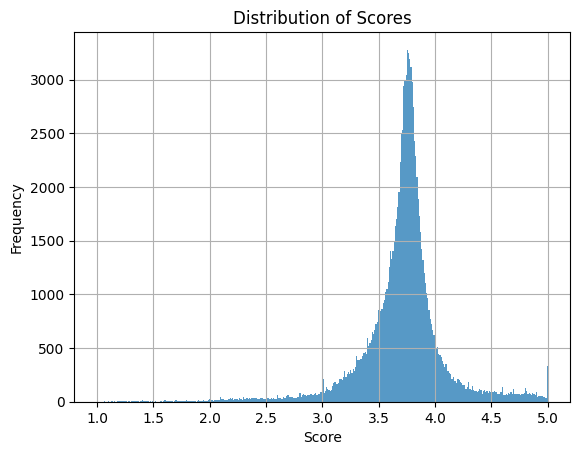

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

# Read the CSV file into df
file_path = 'FinalDictionary.csv'
df = pd.read_csv(file_path)

# Read score data
scores = df['Score']

# Plot the histogram
plt.hist(scores, bins= 'auto', alpha = 0.75)
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Distribution of Scores')
plt.grid(True)
plt.show()